In [54]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import ast
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint
import pickle
import os

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords


from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary, datapath
import gensim

### Data Extraction for Topic Modelling
1. remove duplicated records (talks with same title but different collect date => drop all dup_records in Apr)
2. concat 'title', 'description', 'related tags', 'transcript'
3. drop speaker info from title and description (irrelevant for topic modelling)
4. remove comments and sentiment (irrelevant to this task)

In [201]:
def data_extractor(file):
    """Preprocess the talks data (with collect date) for lda modelling
    """
    talks = pd.read_csv(file)

    # convert date string to datetime format
    talks['publish_date']=list(pd.to_datetime(talks['publish_date']))
    talks['publish_date']=talks['publish_date'].dt.to_period('M')

    #sort by publish date
    talks.sort_values(by=['publish_date'], inplace = True, ignore_index = True)

    # remove duplicated records (talks with same title but different collect date => drop all dup_records in Apr)
    apr_titles = set(talks[talks['collect_date'] == 'Apr 2012']['title'])
    sep_titles = set(talks[talks['collect_date'] == 'Sep 2012']['title'])
    overlap = apr_titles.intersection(sep_titles)
    talks.drop(talks.loc[(talks['collect_date'] == 'Apr 2012') & (talks["title"].isin(overlap))].index, inplace=True)
    talks.reset_index(drop=True, inplace = True)

    # drop 22 rows where publish date is missing
    talks.dropna(subset=['publish_date'], inplace = True)
    talks.reset_index(drop=True, inplace = True)
    
    #remove the speaker's name from title and description
    cleaned_titles = []
    cleaned_description = []
    for speaker, title, des in zip(talks['speaker'].values, talks['title'].values, talks['description'].values):
        cleaned_titles.append(re.sub(speaker, '', title))
        cleaned_description.append(re.sub(speaker, '', des))
    talks['title'] = cleaned_titles
    talks['description'] = cleaned_description

    #construct document corpus where each row corresponds with one title (index)
    talks.loc[talks['transcript'].isnull(), 'transcript'] = str('')
    corpus_data = {'title': talks['title'], 
                'publish_date': talks['publish_date'], 
                'tags': talks['related_tags'], 
                ''
                'contents': talks['title'] + ' ' + talks['description'] + ' '+ talks['transcript']}
    docs = pd.DataFrame(corpus_data)

    return docs

In [202]:
docs, talks = data_extractor("processed_data/talks_without_duplication.csv")

In [203]:
talks.to_csv("processed_data/talks_orderbytime_1402.csv")

### Data preprocessing
1. Tockenize contents (title + description + transcript)
2. stop words removal (including some annotations common in Ted ==> (Applause), (Laughter), and speakers)
3. Stemming

In [146]:
# Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
def clean_transcript(text):
    text = text.lower() # lowercase
    text = re.sub('\(.*?\)', '', text)  # words inside of a () are commonly reactions from the audiences
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub('\w*\d\w*', '', text) # remove digits
    #text = re.sub('a+h+ ', '', text) # remove 语气词
    return text

In [147]:
cleaned_doc = docs
# add related tags into the transcripts
tags = docs['tags'].apply(lambda x: ' '.join(ast.literal_eval(x)) if type(x) is str else ' '.join(x))
cleaned_doc['contents'] = tags + ' ' + docs['contents']
# clean the transcript
cleaned_doc['contents'] = docs.contents.apply(lambda x: clean_transcript(x))
cleaned_doc.to_csv("Topic_modelling_data/cleaned_documents.csv")

#### Extract only nouns

In [149]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [150]:
data_nouns = pd.DataFrame(cleaned_doc.contents.apply(nouns))
data_nouns.to_csv("Topic_modelling_data/doc_only_nouns.csv")

#### Extract N & Adj.

In [21]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [24]:
data_nouns_adj = pd.DataFrame(cleaned_doc.contents.apply(nouns_adj))
data_nouns_adj.to_csv("Topic_modelling_data/doc_nouns_adj.csv")

#### Stemming

In [114]:
# stemming stop words
def semmatize_stop_words(w):
    ps = PorterStemmer()
    return ps.stem(w)

# extend stop words to include stems
def get_stop_words():
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're' , 'use', 'rt','thing','way','year','people','time'])
    stop_words_stem = [semmatize_stop_words(x) for x in stop_words]
    stop_words.extend(stop_words_stem)
    stop_words = list(dict.fromkeys(stop_words))

    return stop_words

# stemming the text
def semmatize_text(text):
    ps = PorterStemmer() 
    return [ps.stem(w)  for w in text if len(w)>3]

def tokenize_text(doc):
    return doc.apply(lambda row: nltk.word_tokenize(row['contents']), axis=1)

def remove_stopwords(texts):
    return [ word for word in texts if word not in stop_words ]

def process_lda_format(doc):
    tokenized_df = tokenize_text(doc)

    stemmed_dataset = tokenized_df.apply(semmatize_text)
    stemmed_dataset = stemmed_dataset.map(lambda x: remove_stopwords(x))
    return stemmed_dataset

def initialize_corpus_and_dictionary(stemmed_dataset):
    
    dictionary_of_words = gensim.corpora.Dictionary(stemmed_dataset)
    word_corpus = [dictionary_of_words.doc2bow(word) for word in stemmed_dataset]
    
    return word_corpus, dictionary_of_words

def lda_datasets(doc):
    stemmed_dataset = process_lda_format(doc)
    corpus, dictionary = initialize_corpus_and_dictionary(stemmed_dataset)
    
    return stemmed_dataset, corpus, dictionary

In [172]:
#  perform stemming on transcripts with only nouns
data_nouns = pd.read_csv("Topic_modelling_data/doc_only_nouns.csv")
stop_words = get_stop_words()
stemmed_dataset, corpus, dictionary = lda_datasets(data_nouns)
stemmed_dataset.to_csv('Topic_modelling_data/stemmed_dataset.csv')
pickle.dump(corpus, open("Topic_modelling_data/corpus.pkl", "wb"))
pickle.dump(dictionary, open("Topic_modelling_data/dictionary.pkl", "wb"))

#### Test the LDA model on stemming dataset

In [22]:
def run_lda(topic_num, corpus, dictionary, stemmed_dataset):
    
    # Model with the best coherence_value
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=topic_num,
                                            random_state=1, update_every=1, chunksize=100,
                                            passes=50, alpha='auto', per_word_topics=True)

    cwd = os.getcwd()
    temp_file = datapath(os.path.join(cwd, "LDA_models/lda_model_"+str(topic_num)))
    print('Model is saving... at', temp_file)
    lda_model.save(temp_file)

    
    # Compute Perplexity Score
    print('Perplexity Score: ', lda_model.log_perplexity(corpus)) 
    
    # Compute Coherence Score
    cohr_val = CoherenceModel(model=lda_model, texts=stemmed_dataset, dictionary=dictionary,
                                      coherence='c_v').get_coherence()

    print('Coherence Score: ', cohr_val)

In [174]:
def run_malletlda(topic_num, corpus, dictionary, stemmed_dataset):

    mallet_path = '/Users/qyq/Documents/Documents/mallet-2.0.8/bin/mallet'

    # Model with the best coherence_value
    lda_model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, id2word=dictionary, num_topics=topic_num, random_seed = 1)

    cwd = os.getcwd()
    temp_file = datapath(os.path.join(cwd, "LDA_models/lda_model_" + str(topic_num) + "_mallet"))
    print('Model is saving... at', temp_file)
    lda_model.save(temp_file)

    # Show Topics
    pprint(lda_model.show_topics(formatted=False))
    
    # Compute Coherence Score
    cohr_val = CoherenceModel(model=lda_model, texts=stemmed_dataset, dictionary=dictionary,
                                      coherence='c_v').get_coherence()

    print('Coherence Score: ', cohr_val)
    
    return cohr_val

##### （1）LDA + 8 topics

In [61]:
run_lda(8, corpus, dictionary, stemmed_dataset)

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_8
Perplexity Score:  -7.96151777190068
Coherence Score:  0.3788263527490286


In [56]:
mallet_path = '/Users/qyq/Documents/Documents/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, id2word=dictionary, num_topics=8)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=stemmed_dataset, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('world', 0.03627168890051443),
   ('countri', 0.02332374226174906),
   ('state', 0.012043334205248932),
   ('busi', 0.01179265847066004),
   ('percent', 0.011781759525677914),
   ('citi', 0.010855349202197228),
   ('dollar', 0.010343098788037318),
   ('govern', 0.010277705118144563),
   ('problem', 0.00992893887871654),
   ('issu', 0.009863545208823786)]),
 (1,
  [('technolog', 0.0326530612244898),
   ('design', 0.03260932944606414),
   ('comput', 0.022201166180758018),
   ('music', 0.017667638483965013),
   ('kind', 0.01706997084548105),
   ('machin', 0.014402332361516034),
   ('idea', 0.013979591836734693),
   ('video', 0.011545189504373178),
   ('someth', 0.010889212827988338),
   ('engin', 0.010612244897959184)]),
 (2,
  [('someth', 0.014977487825048241),
   ('stori', 0.013599191399430305),
   ('kind', 0.011525183444690933),
   ('book', 0.011105131200693086),
   ('work', 0.01035691314107192),
   ('film', 0.009398668959451831),
   ('sort', 0.009083629776453446),
   ('dont',

In [100]:
# Load a potentially pretrained model from disk.
lda_model8 = models.ldamodel.LdaModel.load("LDA_models/lda_model_8_mallet")
lda_model8.print_topics()

[(0,
  '0.022*"citi" + 0.019*"food" + 0.018*"design" + 0.017*"energi" + 0.016*"build" + 0.013*"water" + 0.012*"idea" + 0.011*"world" + 0.011*"kind" + 0.010*"product"'),
 (1,
  '0.026*"stori" + 0.023*"world" + 0.017*"women" + 0.017*"life" + 0.009*"cultur" + 0.009*"girl" + 0.009*"woman" + 0.009*"game" + 0.007*"children" + 0.007*"famili"'),
 (2,
  '0.032*"brain" + 0.017*"someth" + 0.015*"experi" + 0.015*"kind" + 0.012*"languag" + 0.011*"mind" + 0.011*"life" + 0.011*"exampl" + 0.010*"fact" + 0.009*"person"'),
 (3,
  '0.025*"technolog" + 0.018*"comput" + 0.015*"univers" + 0.014*"space" + 0.014*"life" + 0.013*"kind" + 0.011*"idea" + 0.011*"scienc" + 0.011*"inform" + 0.010*"machin"'),
 (4,
  '0.016*"someth" + 0.015*"kind" + 0.015*"music" + 0.013*"book" + 0.013*"work" + 0.012*"design" + 0.010*"sort" + 0.009*"piec" + 0.008*"entertain" + 0.007*"word"'),
 (5,
  '0.019*"school" + 0.018*"health" + 0.017*"kid" + 0.016*"cell" + 0.014*"children" + 0.013*"diseas" + 0.013*"cancer" + 0.012*"bodi" + 0.012

#### Hyperparameter tuning

In [160]:
def hyper_tuning(corpus, dictionary, stemmed_dataset):
    """ Try out diff topic numbers
    """
    cv = []

    for i in range (1, 15):
        lda_model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, id2word=dictionary, num_topics=i, random_seed = 1)

        cwd = os.getcwd()
        temp_file = datapath(os.path.join(cwd, "LDA_models/lda_model_"+str(i) + "_mallet"))
        print('Model is saving... at', temp_file)
        lda_model.save(temp_file)
        
        # Compute Coherence Score
        cohr_val = CoherenceModel(model=lda_model, texts=stemmed_dataset, dictionary=dictionary,
                                        coherence='c_v').get_coherence()
        cv.append(cohr_val)

    return cv

In [178]:
cv = hyper_tuning(corpus, dictionary, stemmed_dataset)
pickle.dump(cv, open("Vis/cv_topic_numns.pkl", "wb"))

Mallet LDA: 1 topics, 0 topic bits, 0 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -8.03478
<20> LL/token: -8.03478
<30> LL/token: -8.03478
<40> LL/token: -8.03478

0	50	world someth kind life idea technolog problem stori place system work part fact brain today question design countri cours percent 

<50> LL/token: -8.03478
<60> LL/token: -8.03478
<70> LL/token: -8.03478
<80> LL/token: -8.03478
<90> LL/token: -8.03478

0	50	world someth kind life idea technolog problem stori place system work part fact brain today question design countri cours percent 

<100> LL/token: -8.03478
<110> LL/token: -8.03478
<120> LL/token: -8.03478
<130> LL/token: -8.03478
<140> LL/token: -8.03478

0	50	world someth kind life idea technolog problem stori place system work part fact brain today question design countri cours percent 

<150> LL/token: -8.03478
<160> LL/token: -8.03478
<170> LL/token: -8.03478
<180> LL/token: -8.03478
<190> LL/token: -8.03478

0	50	world someth k

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_1_mallet


Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -8.58928
<20> LL/token: -8.44214
<30> LL/token: -8.36074
<40> LL/token: -8.31808

0	25	life someth brain world kind school question cell children book women person problem kid bodi cours stori scienc word experi 
1	25	world kind idea someth design technolog place system countri water space citi problem project energi stori power today busi dollar 

<50> LL/token: -8.29187
<60> LL/token: -8.27643
<70> LL/token: -8.26661
<80> LL/token: -8.26004
<90> LL/token: -8.25549

0	25	life someth brain kind book stori school cell children person question word women experi kid world bodi cours work hand 
1	25	world kind idea place design countri technolog someth system water space problem citi energi project percent today power busi dollar 

<100> LL/token: -8.25158
<110> LL/token: -8.24819
<120> LL/token: -8.24635
<130> LL/token: -8.24562
<140> LL/token: -8.24243

0	25	life someth brai

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_2_mallet


Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -8.86842
<20> LL/token: -8.56035
<30> LL/token: -8.43316
<40> LL/token: -8.38084

0	16.66667	someth kind idea stori life world book word brain work question experi person univers sort mind part languag cours exampl 
1	16.66667	technolog water kind life design system energi someth planet anim earth comput place stuff scienc space music sort part machin 
2	16.66667	world countri percent problem today women state school money children dollar commun busi food health cell system chang power issu 

<50> LL/token: -8.34787
<60> LL/token: -8.32908
<70> LL/token: -8.31794
<80> LL/token: -8.30813
<90> LL/token: -8.29999

0	16.66667	someth kind life stori idea book world word work brain experi question person game music mind sort moment hand cours 
1	16.66667	technolog kind water life energi system design someth space planet comput anim earth place world scienc build stuff cell mach

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_3_mallet


Mallet LDA: 4 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.03018
<20> LL/token: -8.62329
<30> LL/token: -8.48733
<40> LL/token: -8.43178

0	12.5	world countri stori percent school problem women money children state dollar today busi kid famili commun govern power issu societi 
1	12.5	brain life cell someth bodi music person mind cancer hand patient experi diseas love part languag heart scienc cours kind 
2	12.5	water energi space life univers world planet earth place anim scienc speci system pictur natur someth kind ocean forc matter 
3	12.5	kind someth idea design technolog sort work comput citi project world book build machin data stuff inform problem point video 

<50> LL/token: -8.40081
<60> LL/token: -8.38325
<70> LL/token: -8.37616
<80> LL/token: -8.3679
<90> LL/token: -8.3635

0	12.5	world countri stori percent women school problem money state children today dollar famili busi commun kid govern issu societi power 
1	12.

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_4_mallet


Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.18986
<20> LL/token: -8.7133
<30> LL/token: -8.54493
<40> LL/token: -8.4762

0	10	space univers music life kind world planet scienc place earth someth light matter energi forc pictur sound number question pattern 
1	10	stori life world women school children cultur someth kid friend dont person woman mother work book girl word love famili 
2	10	water cell anim life bodi food speci cancer patient ocean plant organ system heart diseas gene tree area scienc environ 
3	10	world countri problem percent citi dollar today state busi system money govern power idea compani place market chang africa technolog 
4	10	kind someth design brain sort idea technolog comput work inform machin game book project exampl piec part hand word stuff 

<50> LL/token: -8.43624
<60> LL/token: -8.41465
<70> LL/token: -8.40185
<80> LL/token: -8.39483
<90> LL/token: -8.3899

0	10	space univers music

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_5_mallet


Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.2877
<20> LL/token: -8.77317
<30> LL/token: -8.60783
<40> LL/token: -8.53621

0	8.33333	world countri school women children money kid state commun problem govern busi societi today dollar famili africa power issu girl 
1	8.33333	brain cell data health technolog cancer diseas life bodi patient system problem percent research organ studi scienc number exampl fact 
2	8.33333	idea kind someth design game music life world sort technolog book scienc univers student question piec stuff point work video 
3	8.33333	space kind comput someth machin light inform build languag object brain project system sort robot univers imag technolog pictur engin 
4	8.33333	stori someth life word person work friend book hand moment mind experi love film dont kind somebodi play head face 
5	8.33333	water world citi energi place food planet system anim life earth ocean product speci plant percen

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_6_mallet


Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.34412
<20> LL/token: -8.76794
<30> LL/token: -8.60322
<40> LL/token: -8.53055

0	7.14286	brain comput kind univers machin scienc someth languag inform exampl idea question experi number robot pattern hand sound theori mind 
1	7.14286	technolog cell energi bodi system cancer diseas life patient organ health data gene heart someth problem research percent care today 
2	7.14286	water planet earth food world anim life speci ocean plant place tree natur kind area environ system fact fish theyr 
3	7.14286	someth book music work game kind word kid film cultur stori experi media world point idea life person moment audienc 
4	7.14286	design kind someth idea build space sort place citi project stuff pictur play work engin part life light technolog car 
5	7.14286	stori life women children world mother woman famili girl love child babi live father school person death dont religio

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_7_mallet


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.42435
<20> LL/token: -8.86396
<30> LL/token: -8.68075
<40> LL/token: -8.599

0	6.25	world cultur book someth languag word kind question life idea stori person group exampl friend histori fact internet phone religion 
1	6.25	world citi technolog energi system power build problem idea place water project percent chang plant stuff area today product materi 
2	6.25	stori life mother hand world film woman home moment night live happi father photograph dont face tree month hour movement 
3	6.25	brain cell bodi cancer diseas patient technolog research scienc system health problem gene organ inform data life studi part heart 
4	6.25	world countri money percent busi school food kid children dollar problem govern market africa state choic women compani today famili 
5	6.25	univers space game world life matter girl forc women scienc question number star student place school teac

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_8_mallet


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.46938
<20> LL/token: -8.88955
<30> LL/token: -8.68204
<40> LL/token: -8.58748

0	5.55556	someth question kind life experi brain languag exampl mind word problem person choic work fact group case cours answer love 
1	5.55556	cell brain bodi data cancer diseas patient health food system heart research technolog care problem gene percent organ doctor inform 
2	5.55556	world countri percent dollar money state govern problem busi market africa today chang issu system economi compani china societi fact 
3	5.55556	citi world idea place word kind build phone cultur street rule cours someth hous york religion power photo live fact 
4	5.55556	technolog energi world music game kind sound someth power idea engin product today piec point car compass video system problem 
5	5.55556	water planet life anim earth place speci ocean world plant tree feet area natur climat system fish t

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_9_mallet


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.55266
<20> LL/token: -8.90948
<30> LL/token: -8.69811
<40> LL/token: -8.60831

0	5	imag pictur forc stori photograph everyth someth pattern particl place hole side mountain photo shape color natur charg face wind 
1	5	design kind idea someth work sort build project comput music book machin piec word page form artist video part citi 
2	5	life someth person word love book question mind friend languag experi student play hand dont cultur teacher film cours somebodi 
3	5	technolog problem system data compani dollar inform busi percent exampl citi choic product market phone kind someth today internet network 
4	5	life univers space scienc planet kind world earth idea game matter someth star theori energi fact system question number galaxi 
5	5	school children stori women kid famili life woman mother girl home child world hous commun babi place month live parent 
6	5	worl

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_10_mallet


Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.56337
<20> LL/token: -8.9109
<30> LL/token: -8.71019
<40> LL/token: -8.62149

0	4.54545	kind book word idea someth languag rule kid problem sort question cours place citi friend model reason exampl experi stuff 
1	4.54545	life someth cultur question mind stori happi point person cours everybodi work reason someon number somebodi dont anyth experi truth 
2	4.54545	anim water ocean speci life world fish earth planet area light bacteria theyr place live environ bird creatur human system 
3	4.54545	music sound life video moment song world minut piec voic stori hour entertain night call record eye kind feet experi 
4	4.54545	technolog comput data inform kind machin someth world idea internet engin phone exampl number today compani sort media stuff problem 
5	4.54545	life univers space scienc planet game world kind earth evolut idea matter theori gene star question patter

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_11_mallet


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.56663
<20> LL/token: -8.93463
<30> LL/token: -8.73952
<40> LL/token: -8.65227

0	4.16667	brain bodi love mind babi hand cell abil children life research anim person part eye emot human memori scienc fact 
1	4.16667	world percent countri problem dollar money energi today govern chang state economi market compani africa china popul busi growth issu 
2	4.16667	design citi build project kind work place play someth space idea sort hous imag artist film wall street architectur york 
3	4.16667	idea someth kind world technolog word languag exampl media internet cultur inform religion friend life network fact book problem person 
4	4.16667	food game kind world stuff product compani busi someth kid work point theyr dollar market card yeah dont guy farmer 
5	4.16667	question group choic rule kind world valu answer societi problem sens reason idea differ commun point percent fa

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_12_mallet


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.57181
<20> LL/token: -8.93632
<30> LL/token: -8.73988
<40> LL/token: -8.65163

0	3.84615	someth kind question experi life point cultur cours hand reason moment mind somebodi anyth noth group fact answer dont everybodi 
1	3.84615	citi stori someth place work book kind play world pictur york photograph street week photo phone theyr home meet imag 
2	3.84615	idea busi technolog compani problem system world choic exampl kind rule product societi market innov model group valu commun cost 
3	3.84615	water planet earth ocean place light space star system surfac galaxi feet life mile scienc pictur hole size area wind 
4	3.84615	world countri state govern money africa power dollar issu problem today nation secur histori death percent news place commun cours 
5	3.84615	world percent energi food data countri growth problem popul technolog chang today system futur dollar health

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_13_mallet


Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.64018
<20> LL/token: -8.98759
<30> LL/token: -8.78173
<40> LL/token: -8.68718

0	3.57143	univers music comput machin sound theori scienc someth hand idea number pattern matter question play forc space particl kind physic 
1	3.57143	food plant water anim speci tree ocean fish natur card place theyr island kind area ant shark forest farm boat 
2	3.57143	brain cell technolog life bodi organ gene inform system evolut molecul biolog fact speci bacteria process scienc human exampl part 
3	3.57143	kind build sort citi stuff someth design space project place idea pictur work galaxi center technolog comput wall hous structur 
4	3.57143	planet earth life robot light surfac system space scienc anim world technolog star engin ocean creatur hole scientist feet water 
5	3.57143	state power world societi problem histori case news secur countri forc death today issu conflict polit 

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_14_mallet


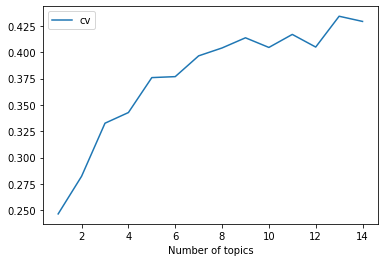

In [180]:
x = [i for i in range(1, 15)]
plt.plot(x, cv, label = "cv")
plt.xlabel('Number of topics')
plt.legend()
plt.show()

In [ ]:
# test different alpha with 8 topics
cv_alpha = []
alphas = np.arange(10, 100, 20)
for alpha in alphas:
    lda_model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, id2word=dictionary, num_topics=8, alpha = alpha, random_seed = 1)
    # Compute Coherence Score
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=stemmed_dataset, dictionary=dictionary, coherence='c_v')
    cv_alpha.append(coherence_model_ldamallet.get_coherence())

In [101]:
cv_alpha

[0.39747631516816134,
 0.39747631516816134,
 0.39747631516816134,
 0.39747631516816134,
 0.39747631516816134]

In [169]:
# Load a potentially pretrained model from disk.
lda_model10 = models.wrappers.LdaMallet.load("LDA_models/lda_model_10_mallet")
lda_model10.print_topics()

[(0,
  '0.029*"stori" + 0.017*"imag" + 0.015*"someth" + 0.013*"film" + 0.011*"pictur" + 0.011*"world" + 0.011*"movi" + 0.010*"book" + 0.010*"hand" + 0.009*"photograph"'),
 (1,
  '0.040*"design" + 0.024*"kind" + 0.020*"music" + 0.018*"build" + 0.018*"idea" + 0.015*"someth" + 0.015*"piec" + 0.014*"work" + 0.011*"sort" + 0.011*"project"'),
 (2,
  '0.023*"life" + 0.016*"game" + 0.014*"someth" + 0.013*"kind" + 0.013*"world" + 0.012*"word" + 0.011*"question" + 0.009*"cultur" + 0.009*"languag" + 0.009*"experi"'),
 (3,
  '0.025*"technolog" + 0.015*"kind" + 0.015*"compani" + 0.014*"comput" + 0.013*"someth" + 0.013*"data" + 0.013*"busi" + 0.013*"dollar" + 0.012*"problem" + 0.011*"idea"'),
 (4,
  '0.022*"univers" + 0.020*"space" + 0.019*"life" + 0.015*"planet" + 0.015*"scienc" + 0.014*"earth" + 0.011*"theori" + 0.010*"idea" + 0.010*"kind" + 0.010*"world"'),
 (5,
  '0.027*"school" + 0.024*"children" + 0.023*"women" + 0.021*"kid" + 0.016*"stori" + 0.013*"famili" + 0.013*"life" + 0.012*"girl" + 0.01

In [175]:
run_malletlda(10, corpus, dictionary, stemmed_dataset)

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1123
total tokens: 590737
<10> LL/token: -9.55266
<20> LL/token: -8.90948
<30> LL/token: -8.69811
<40> LL/token: -8.60831

0	5	imag pictur forc stori photograph everyth someth pattern particl place hole side mountain photo shape color natur charg face wind 
1	5	design kind idea someth work sort build project comput music book machin piec word page form artist video part citi 
2	5	life someth person word love book question mind friend languag experi student play hand dont cultur teacher film cours somebodi 
3	5	technolog problem system data compani dollar inform busi percent exampl citi choic product market phone kind someth today internet network 
4	5	life univers space scienc planet kind world earth idea game matter someth star theori energi fact system question number galaxi 
5	5	school children stori women kid famili life woman mother girl home child world hous commun babi place month live parent 
6	5	worl

Model is saving... at /Users/qyq/Desktop/Courses/2022-SS/IML_Vis/Project/Visual_Analytics/LDA_models/lda_model_10_mallet
[(0,
  [('stori', 0.02903232121532468),
   ('imag', 0.01744288482997592),
   ('someth', 0.015406902762279517),
   ('film', 0.013253460190677552),
   ('pictur', 0.01080636635931168),
   ('world', 0.010767212858009828),
   ('movi', 0.010591022102151485),
   ('book', 0.009984142831972749),
   ('hand', 0.009749221824161625),
   ('photograph', 0.00920107280593567)]),
 (1,
  [('design', 0.03974999539077048),
   ('kind', 0.023783624329357104),
   ('music', 0.019893434613470012),
   ('build', 0.017773189033721125),
   ('idea', 0.017644130607127714),
   ('someth', 0.014804845222072678),
   ('piec', 0.01474953446781836),
   ('work', 0.014454543778461993),
   ('sort', 0.011191209277457181),
   ('project', 0.010933092424270359)]),
 (2,
  [('life', 0.023054925841964113),
   ('game', 0.015839148923560177),
   ('someth', 0.01398705012520188),
   ('kind', 0.013009141959668697),
   (

0.4046610384066824